In [2]:
# Imports
import numpy as np
import pandas as pd 
import networkx as nx
import community
import ast
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.ensemble import IsolationForest


import seaborn as sns
sns.set()
sns.set_style('white')
sequential_colors = sns.color_palette('Set3')
from mpl_toolkits.axes_grid1 import make_axes_locatable

# sns.palplot(sequential_colors)


In [3]:
df_allG = pd.read_csv('all_genres.csv')
df_allG.head()

,Unnamed: 0,GENRE,SIM_GENRES,SIM_WEIGHTS,OPP_GENRES,OPP_WEIGHTS,REL_ARTISTS,ARTIST_WEIGHTS,SPOTIFY_URL
0,0,backgroundmusic,"['reiki', 'calminginstrumental', 'yoga', 'back...","['103', '120', '101', '240', '102', '125', '11...","['mahraganat', 'divahouse', 'oldschoolukhiphop...","['160', '100', '121', '110', '135', '136', '12...","['NoemiNucci', 'JuditheAbelsen', 'FabienneWill...","['113', '117', '106', '131', '109', '115', '11...",https://open.spotify.com/user/thesoundsofspoti...
1,1,classicmoroccanpop,"['bluesrock', 'andalusianclassical', 'chaabima...","['103', '107', '109', '100', '102', '103', '10...","['shiverpop', 'gravewave', 'tassieindie', 'est...","['112', '112', '105', '102', '124', '100', '16...","['HajHusseinToulali', 'AbdelhadiBelkheyat', 'H...","['102', '103', '103', '108', '108', '102', '10...",https://open.spotify.com/user/thesoundsofspoti...
2,2,orthodoxchant,"['universitychoir', 'polishchoir', 'ukrainianc...","['102', '105', '107', '104', '106', '240', '10...","['sambass', 'funkybreaks', 'hardbass', 'hardco...","['107', '110', '158', '100', '119', '111', '10...","['LegeArtis', 'PeterMichaelides', 'CapellaGreg...","['114', '100', '160', '127', '115', '115', '10...",https://open.spotify.com/user/thesoundsofspoti...
3,3,tar,"['oud', 'persiantraditional', 'bansuri', 'tar'...","['106', '120', '101', '240', '103', '113', '10...","['happyhardcore', 'aggrotech', 'nightcore', 'b...","['109', '107', '127', '114', '115', '120', '12...","['KiyarashSaket', 'YusefForutan', 'HamidMoteba...","['100', '100', '111', '100', '100', '100', '10...",https://open.spotify.com/user/thesoundsofspoti...
4,4,reggae,"['dancehall', 'brazilianreggae', 'skarevival',...","['109', '105', '114', '101', '100', '127', '11...","['brazilianlo-firock', 'martialindustrial', 'p...","['106', '107', '155', '121', '160', '108', '14...","['TheItals', 'MykalRose', 'JohnnieClark', 'Asw...","['101', '102', '100', '105', '101', '105', '10...",https://open.spotify.com/user/thesoundsofspoti...


In [4]:
play_features = pd.read_csv('play_id_to_features.csv')
play_features['genre'] = df_allG['GENRE']


# for column in play_features.columns[1:13]:
#     e = play_features[column] - play_features[column].mean()
#     play_features[column] = e / play_features[column].std()
display(play_features.head())
len(play_features)

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,2JsqQdMbBC2hh7GjsEjKFg,0.222149,0.073075,4.38,-25.78303,0.66,0.041801,0.922340,0.899800,0.118957,0.095634,92.38971,3.60,backgroundmusic
1,2SoQc6bippmMyUTn1qditv,0.525410,0.645390,4.22,-9.24089,0.72,0.083043,0.468130,0.066672,0.282273,0.695130,119.71814,3.55,classicmoroccanpop
2,1KZMCWImik3vA17zVLJ3c3,0.213119,0.166708,5.39,-18.83644,0.56,0.039690,0.966740,0.210298,0.152561,0.144698,102.87562,3.69,orthodoxchant
3,1i9zTcQqWUBTgIuCgxDW3S,0.439940,0.348418,5.05,-12.84006,0.71,0.055323,0.896280,0.855150,0.141858,0.396229,107.26951,3.60,tar
4,0TcXdt4sbITbwCwwFbKYyd,0.789310,0.518160,5.14,-10.01960,0.53,0.133222,0.148952,0.111601,0.148528,0.736290,118.49993,4.00,reggae


3652

In [5]:
# Generate M matrix
M = []
for idx, row in play_features.iterrows():
    m_vec = [float(i) for i in row[1:13]]
    M.append(m_vec)
M = np.array(M)
print(M.shape)

(3652, 12)


In [6]:
MTM = M.T @ M
MMT = M @ M.T
print(MTM.shape, MMT.shape)

(12, 12) (3652, 3652)


In [7]:
# Choose MTM because it's smaller
evals_MTM, evecs_MTM = np.linalg.eig(MTM)
print(evals_MTM)

[5.42779366e+07 9.03206064e+04 1.01556239e+03 3.06166879e+02
 1.20200699e+02 9.47946826e+01 7.83119738e+01 5.40117987e+01
 6.57181685e+00 4.27830897e+00 2.52805635e+01 3.27429443e+01]


In [53]:
def plot_evecproj(evecs, idx_1, idx_2, M):
    # Get Evecs Needed

    E_k2 = np.array([evecs_MTM[idx_1], evecs_MTM[idx_2]]).T
    ME_k2 = M @ E_k2
    v1_data, v2_data = zip(*ME_k2)
    
    # Outlier Stuff
    df = pd.DataFrame({'x': v1_data, 'y': v2_data})
    iso_forest = IsolationForest(contamination = .1, behaviour = 'new', n_estimators = 300, n_jobs = 4).fit(df)

    iso_f = iso_forest.decision_function(df)
    
    
    # Plotting
    plt.rcParams['figure.dpi'] = 500
    fig, ax = plt.subplots(1, figsize = (10,6))
    color = ax.scatter(df['x'], df['y'], 10, c = iso_f, cmap = 'viridis')
    ax.set_xlabel(r'$v_{}$'.format(idx_1))
    ax.set_ylabel(r'$v_{}$'.format(idx_2))
    ax.set_title('PCA ' + r'$v_{} \times v_{}$ with Isolation Forests'.format(idx_1, idx_2))
    ax.grid(False)
    plt.colorbar(color)
    fig.savefig('./images/' + 'evecs_{}_{}'.format(idx_1, idx_2) + '.png', bbox_inches = 'tight', facecolor = 'w', edgecolor = 'k')
    plt.show()

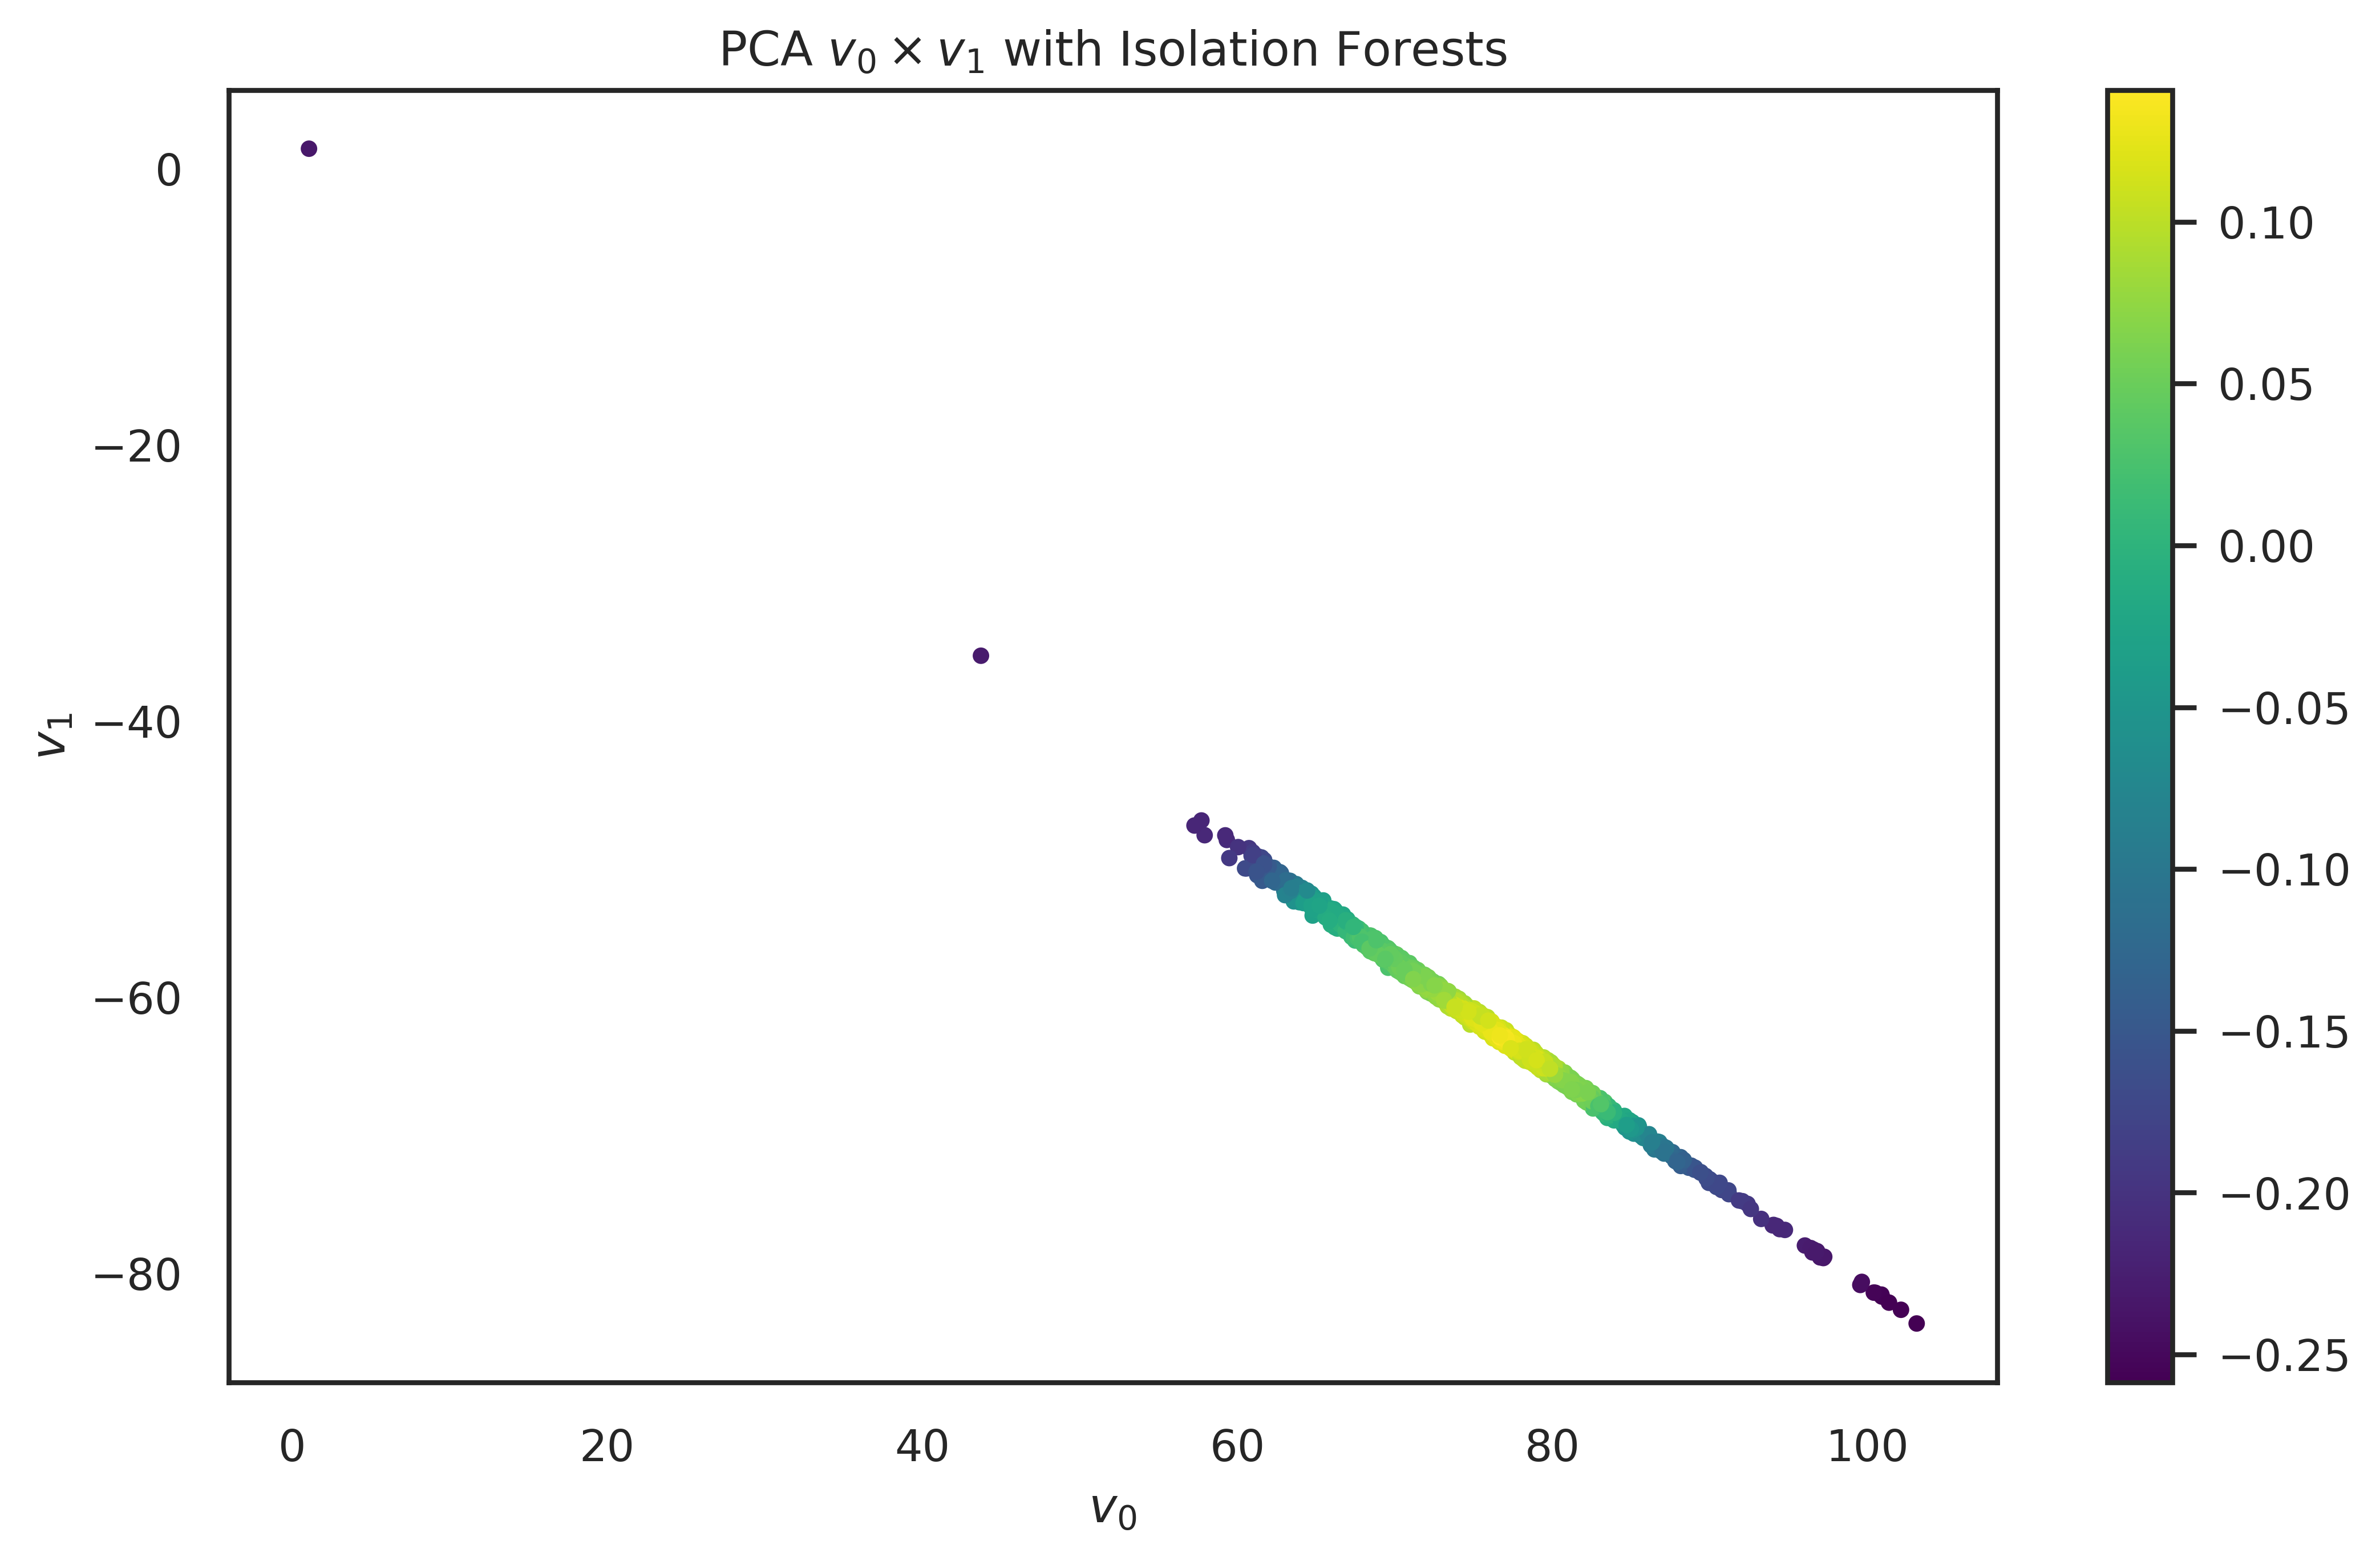

In [54]:
plot_evecproj(evecs_MTM, 0,1, M)

In [55]:
def plot_evecproj_all(evecs, M):

    plt.rcParams['figure.dpi'] = 500
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize = (8.5, 11))
    e1 = 1
    e2 = 2
    for i in range(5):
        for j in range(2):
            
            # Get eigenvectors
            vi = evecs_MTM[e1]
            vj = evecs_MTM[e2]
            E_k2 = np.array([vi, vj]).T
            ME_k2 = M @ E_k2
            
            v1_data, v2_data = list(map(list,zip(*ME_k2)))
            
            # Outlier Stuff
            df = pd.DataFrame({'x': v1_data, 'y': v2_data})
            iso_forest = IsolationForest(contamination = .1, behaviour = 'new', n_estimators = 300, n_jobs = 4).fit(df)
            iso_f = iso_forest.decision_function(df)
            
            # Plotting
            color = axes[i,j].scatter(df['x'], df['y'], s = 10, c = iso_f, cmap = 'viridis', alpha = 0.9)
            xlabel = r'$v_{{{}}}$'.format(e1)
            ylabel = r'$v_{{{}}}$'.format(e2)
            axes[i,j].set_xlabel(xlabel, fontsize = 7)
            axes[i,j].set_ylabel(ylabel, fontsize = 7)
            axes[i,j].set_title(r'PCA ' + r'$v_{{{}}} \times v_{{{}}}$'.format(e1, e2), fontsize = 8)
            axes[i,j].tick_params(axis ='x', labelsize=8)
            axes[i,j].tick_params(axis ='y', labelsize=8)
            axes[i,j].set_yscale('linear')
            axes[i,j].set_xscale('linear')
            axes[i,j].grid(False)
            e1 += 1
            e2 += 1
    im = plt.gca().get_children()[0]
    fig.tight_layout()
    fig.subplots_adjust(right = 0.825, top = 0.93)
    cax = fig.add_axes([0.85, 0.06, 0.035, 0.88])
    fig.colorbar(im, cax = cax)
    fig.suptitle(r'Various $PCA$ Combinations with Isolation Forest Outliers', fontsize = 12)

    plt.show()

    fig.savefig('./images/' + 'evecs_1_11' + '.png', bbox_inches = 'tight', facecolor = 'w', edgecolor = 'k')
    plt.show()

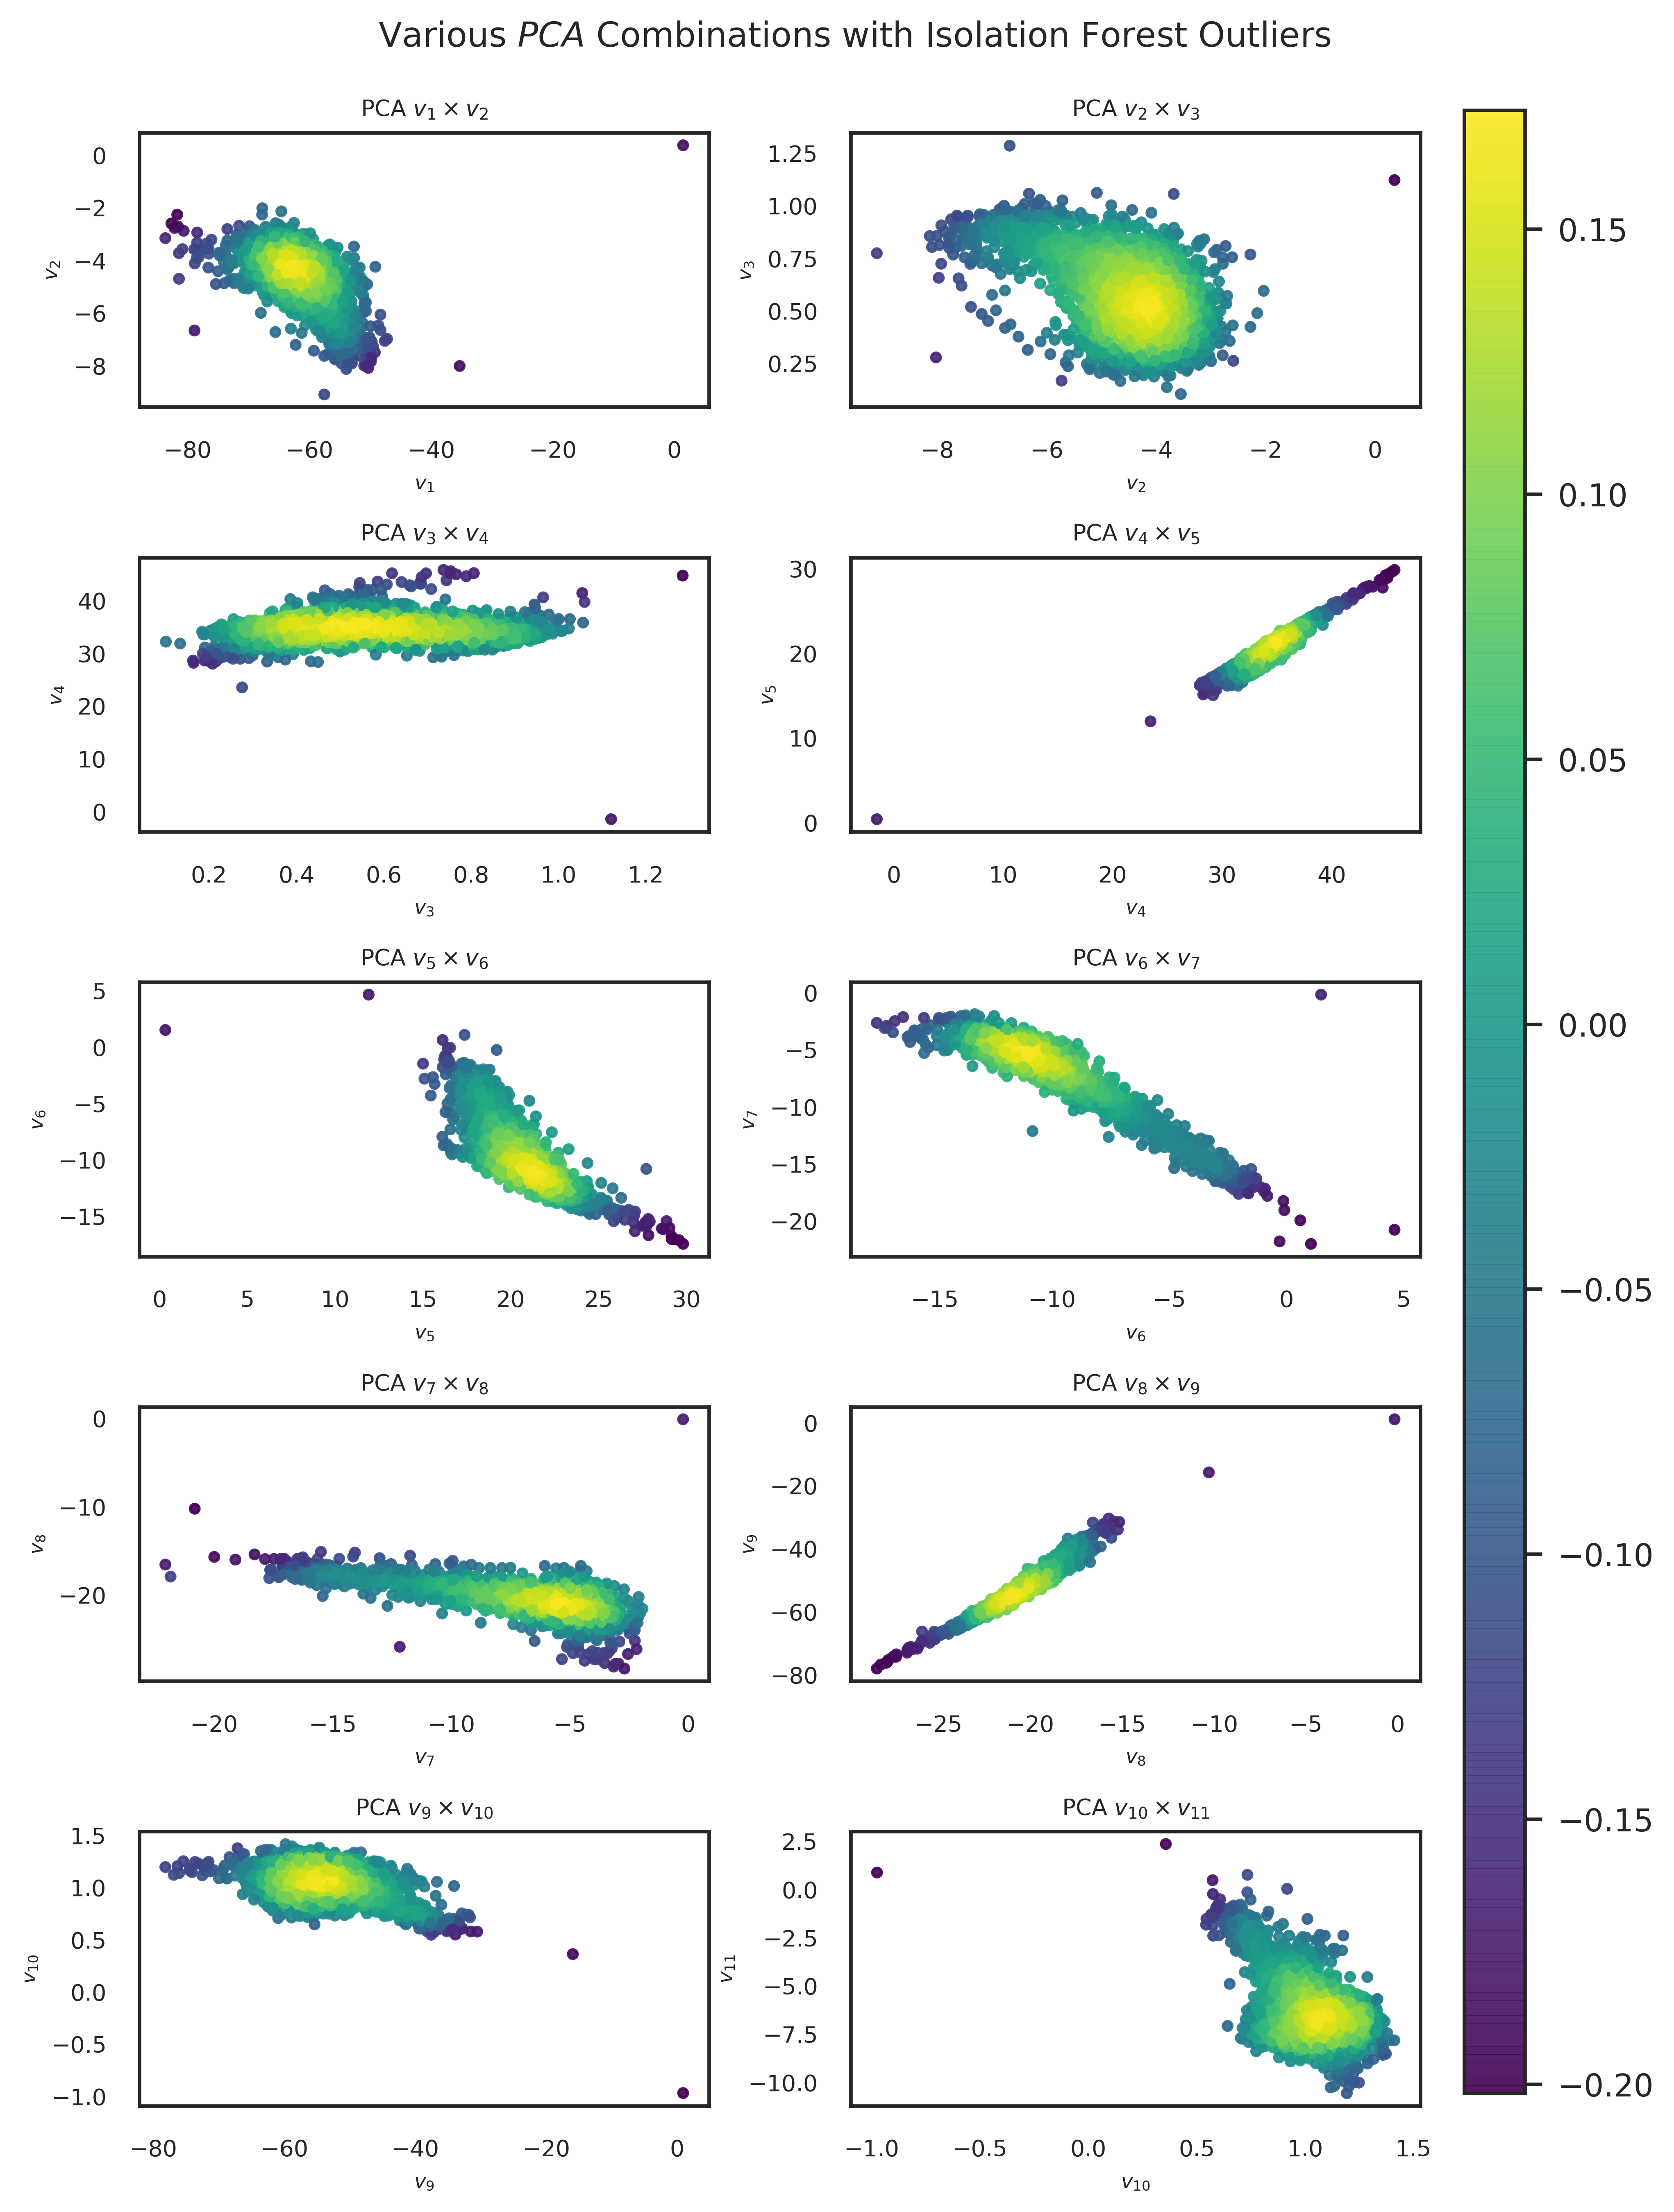

In [56]:
plot_evecproj_all(evecs_MTM, M)

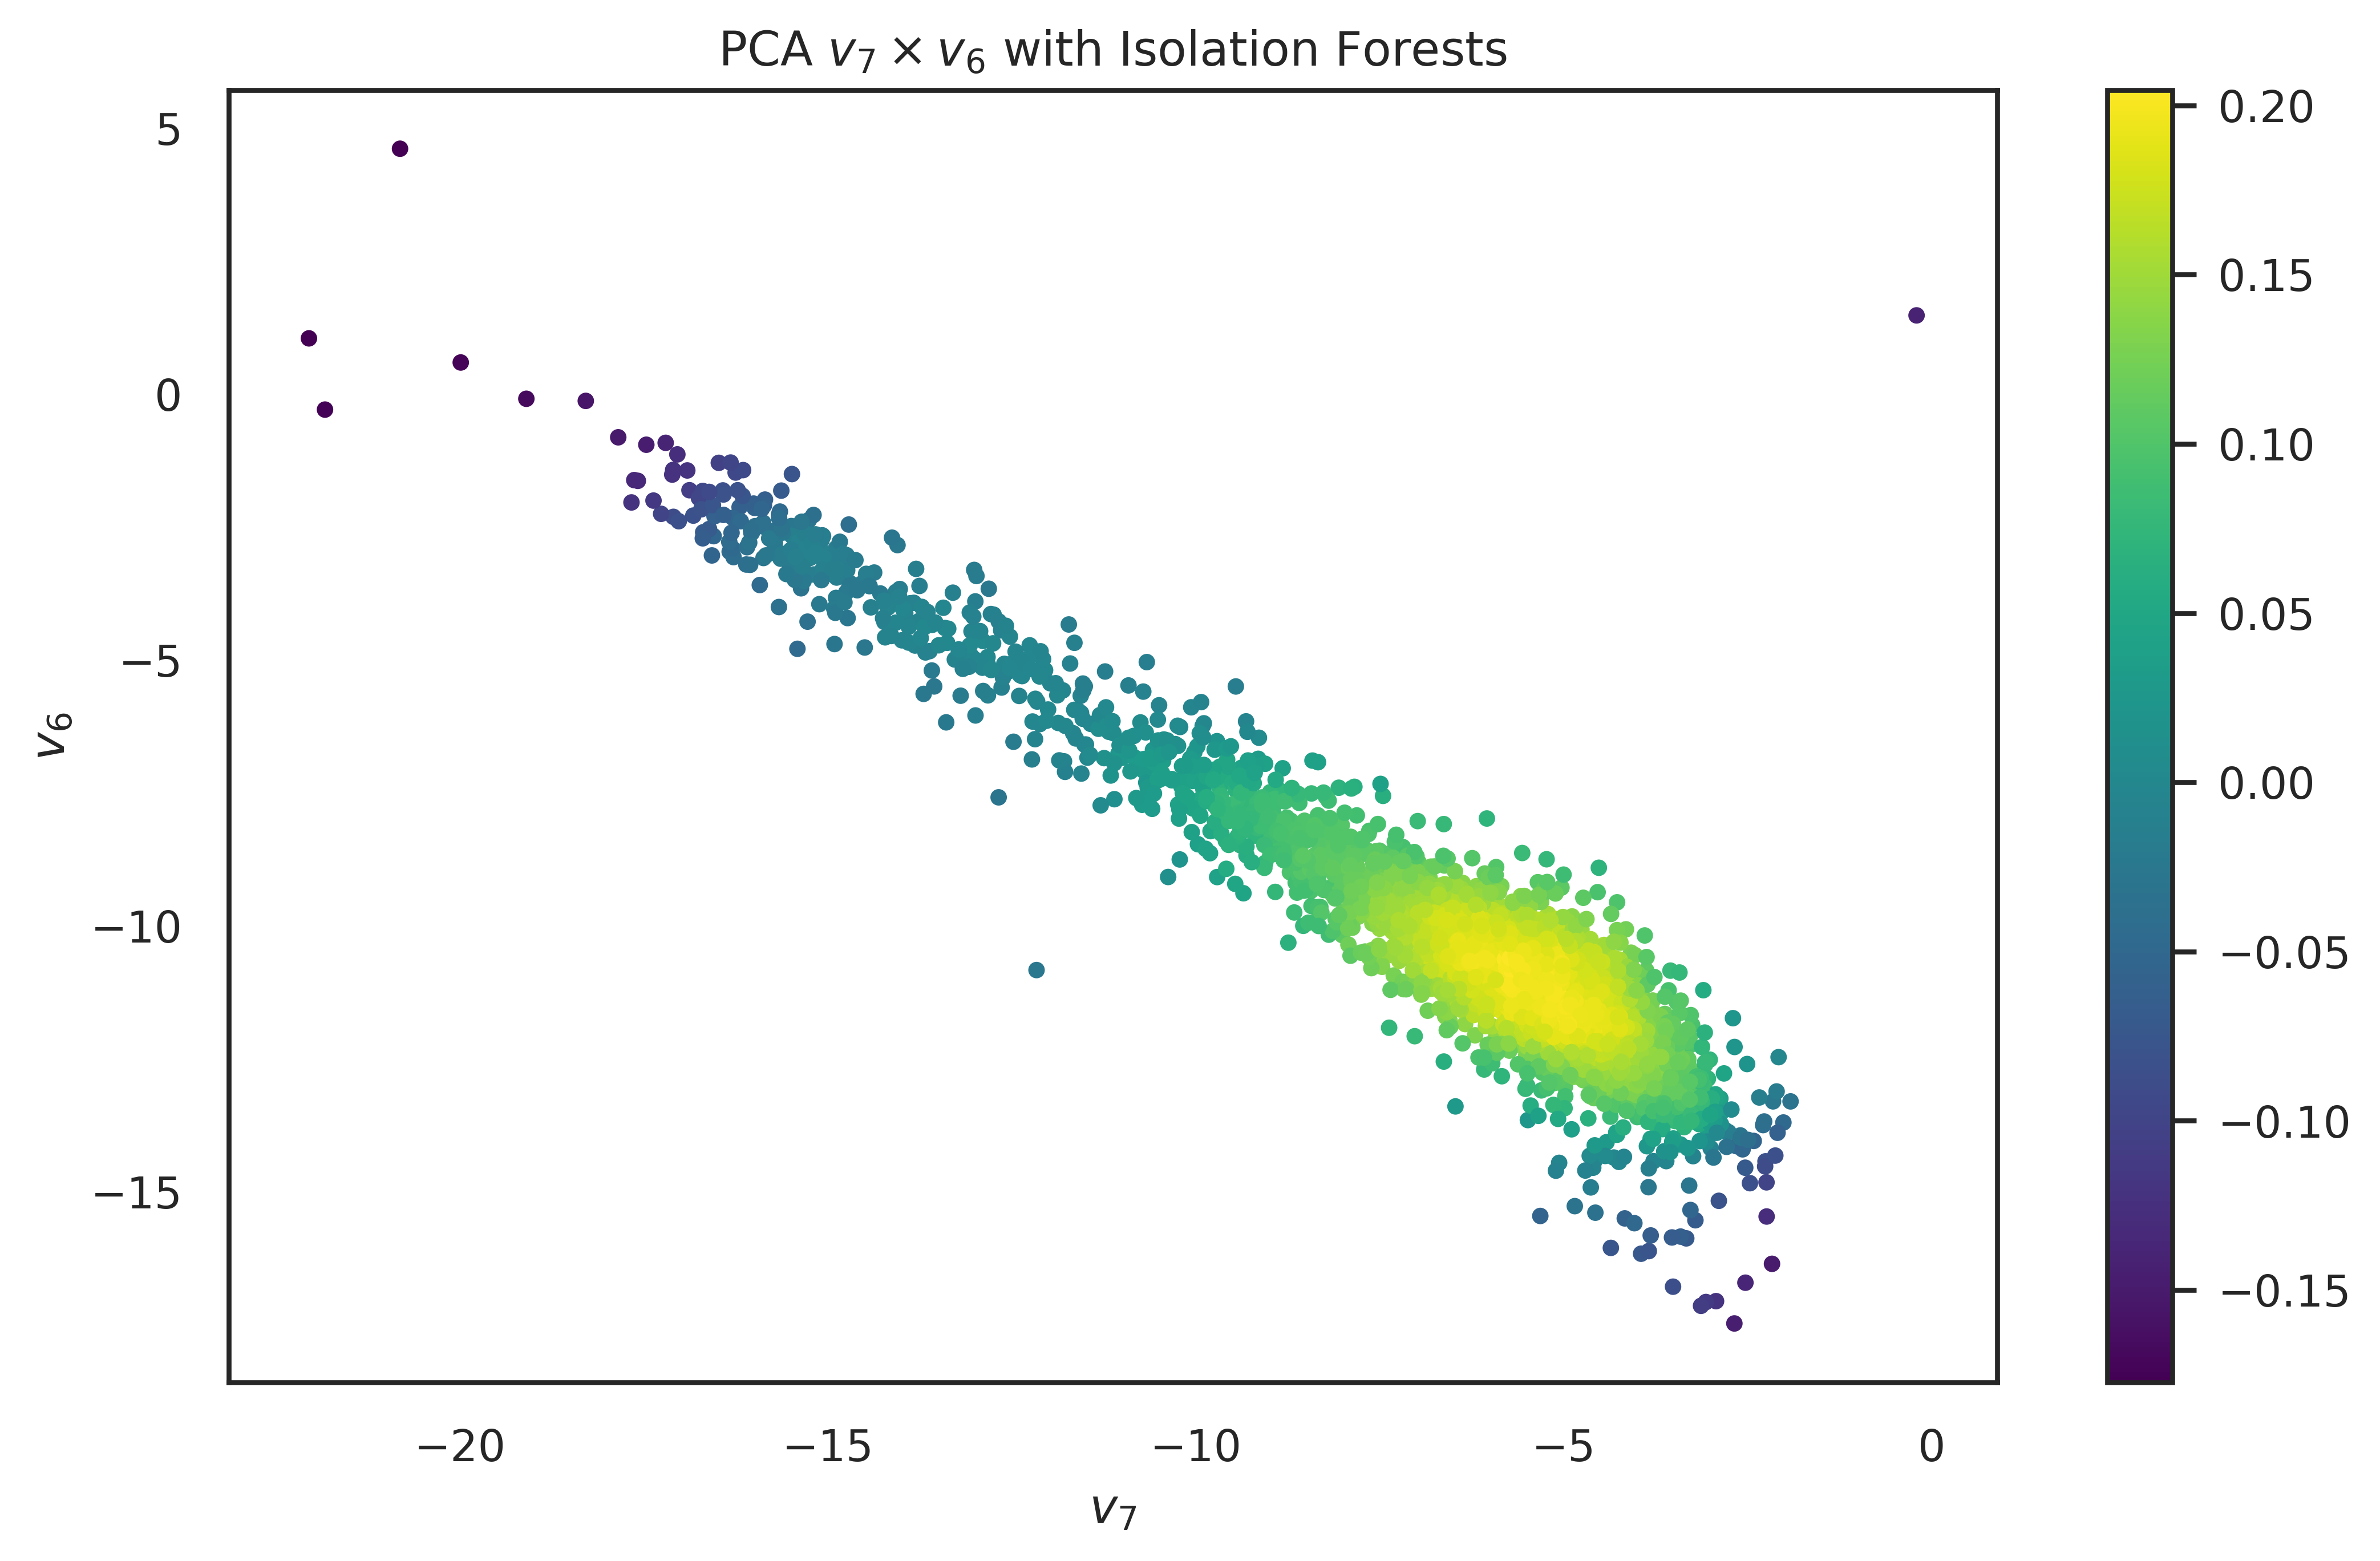

In [57]:
plot_evecproj(evecs_MTM, 7, 6, M)